In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')
nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4') # проводит лемматизацию
nltk.download('punkt_tab')
stopw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bafer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bafer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bafer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Bafer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Bafer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
dp = pd.read_csv("../data/combined_data.csv")
dp["label"] = dp["label"].astype(np.int32)
dp.rename(columns={"label":"is_spam"},inplace=True)

Text(0.5, 1.0, 'Объем выборки')

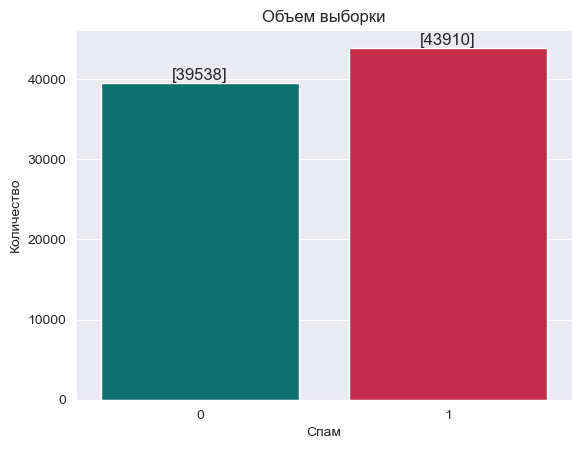

In [3]:
from matplotlib import pyplot as plt

ax = sns.countplot(data=dp, x="is_spam",palette=["teal", "crimson"])
for i, val in enumerate(dp.groupby(by='is_spam').count().values):
    plt.text(i, val, val, horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
ax.set_xlabel('Спам')
ax.set_ylabel('Количество')
ax.set_title('Объем выборки')

In [4]:
English_stopwords=stopw
stemmer=PorterStemmer()


In [9]:
def tokenize(sentence:str)->list[str]:
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z]', ' ', sentence)
    tokens = word_tokenize(sentence)
    return [token for token in tokens]

def morph_stemm(list_of_tokens:list[str])->list[str]:
    return [stemmer.stem(word) for word in list_of_tokens]

def stop_words(list_of_morphs:list[str])->list[str]:
    return [word for word in list_of_morphs if word not in stopw]

def cleaner(sentence:str)->str:
    return " ".join(stop_words(morph_stemm(tokenize(sentence))))
def count_words(sentence):
    return len(sentence)

In [10]:
dp.iloc[:200,1].apply(cleaner)

0      ounc feather bowl hummingbird opec moment alab...
1      wulvob get medirc onlin qnb ikud viagra escape...
2      comput connect cnn com wednesday escapenumb ma...
3      univers degre obtain prosper futur money earn ...
4      thank answer guy know check rsync manual would...
                             ...                        
195    nu microsoft titl releas jun escapenumb escape...
196    complet sandwich commit somewher promis famili...
197    oh dear sir mother say friend onli good emma s...
198    deer valley corpor escapenumb escapenumb targe...
199    dear sir aegi capit group llc aegi specialti i...
Name: text, Length: 200, dtype: object

In [11]:
dp.iloc[:200,1]

0      ounce feather bowl hummingbird opec moment ala...
1      wulvob get your medircations online qnb ikud v...
2       computer connection from cnn com wednesday es...
3      university degree obtain a prosperous future m...
4      thanks for all your answers guys i know i shou...
                             ...                        
195    nu microsoft titles released on jun escapenumb...
196    completely sandwich commit somewhere promised ...
197     oh my dear sir as my mother says our friends ...
198    deer valley corporation escapenumber escapenum...
199    dear sirs aegis capital group llc aegis is a...
Name: text, Length: 200, dtype: object

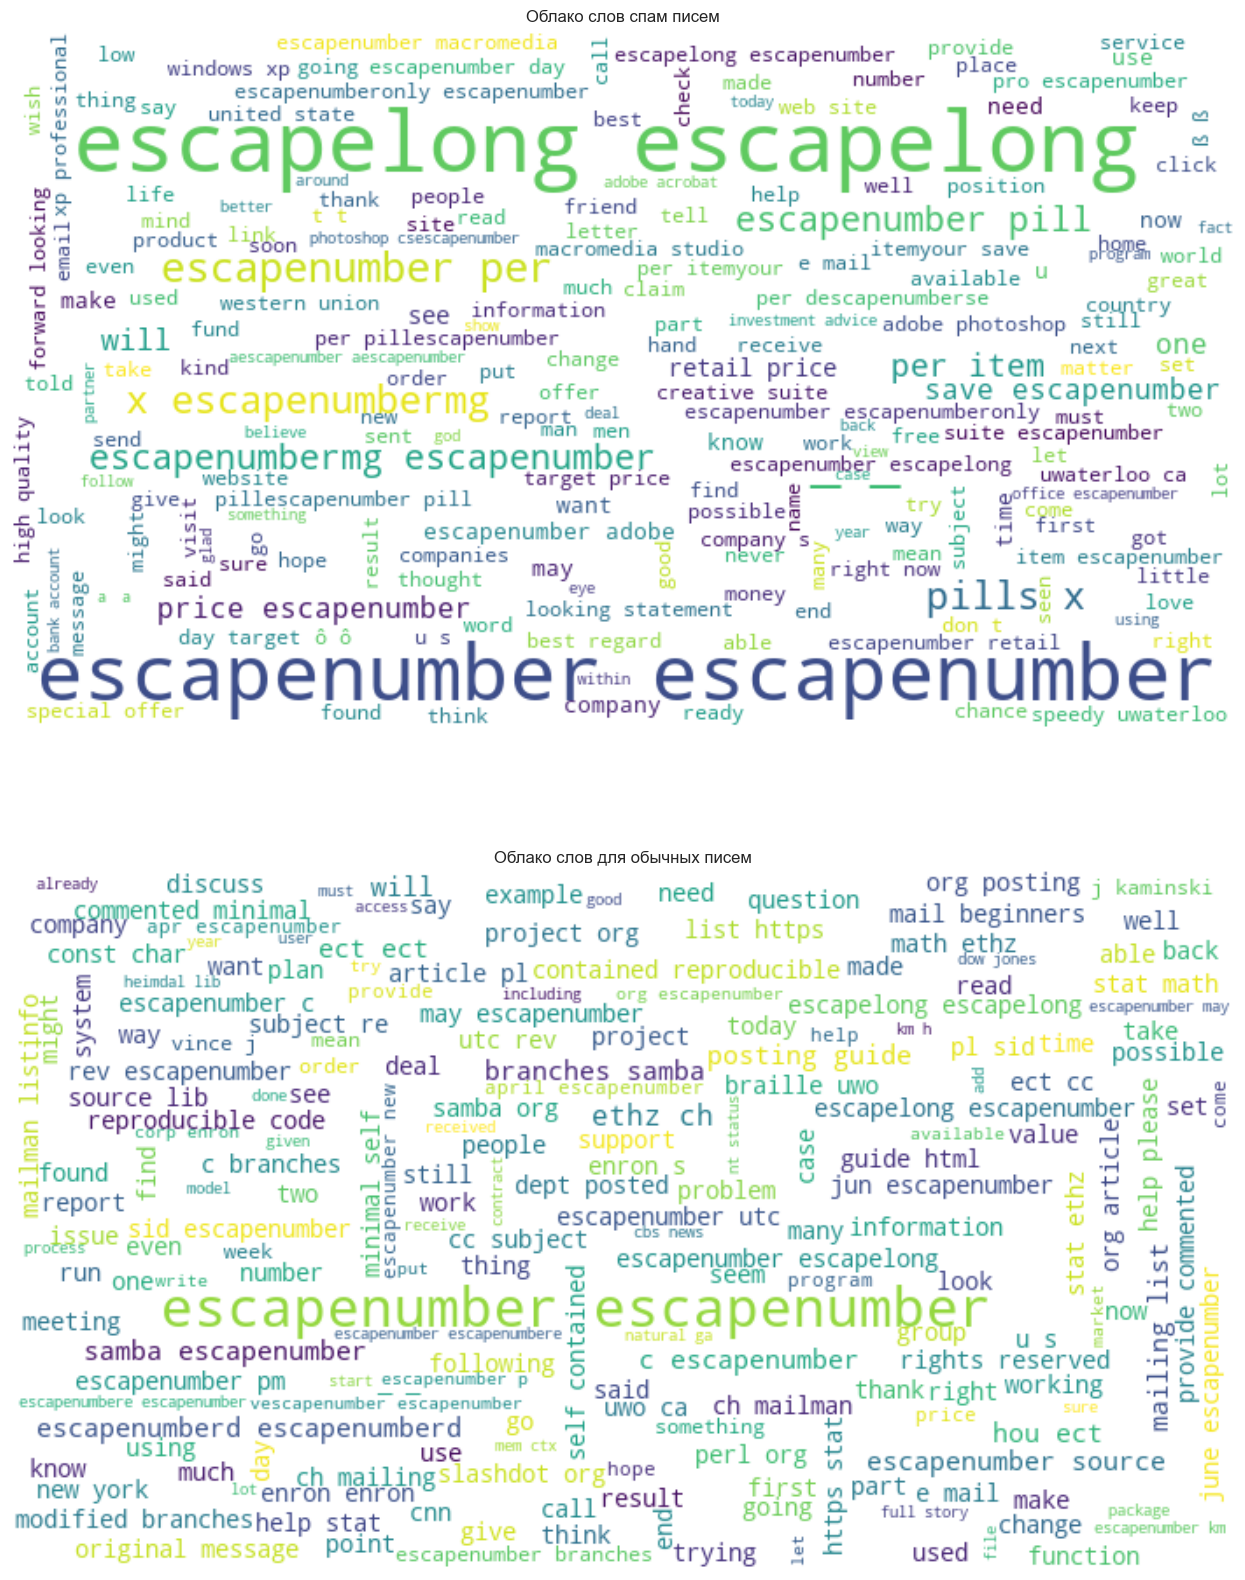

In [7]:
from wordcloud import WordCloud
spam_emails=dp[dp['is_spam']==1]['text']
ham_emails=dp[dp['is_spam']==0]['text']
spam_cloud=WordCloud(width=700,height=400,background_color='white').generate(''.join(spam_emails))
ham_cloud=WordCloud(width=700,height=400,background_color='white').generate(''.join(ham_emails))
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.imshow(spam_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов спам писем')
plt.subplot(2,1,2)
plt.imshow(ham_cloud,interpolation='bilinear')
plt.title('Облако слов для обычных писем')
plt.axis('off')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dp, test_size = .33, random_state = 300,stratify=dp['is_spam'])

In [15]:
train_X = train_data['text']
train_Y = train_data['is_spam']
test_X = test_data['text']
test_Y = test_data['is_spam']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

td = TfidfVectorizer(tokenizer = cleaner,ngram_range=(2, 4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train_tfidf = td.fit_transform(train_X)
X_test_tfidf = td.transform(test_X)

In [17]:
import torch
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

In [18]:
y_train = torch.tensor(train_Y.to_list(), dtype=torch.float32)
y_test = torch.tensor(test_Y.to_list(), dtype=torch.float32)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class TFIDFClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TFIDFClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = X_train_tfidf.shape[1]  # Количество признаков после TF-IDF
hidden_dim = 64
output_dim = 1  # Для бинарной классификации

model = TFIDFClassifier(input_dim, hidden_dim, output_dim)

# Определение критерия и оптимизатора
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Создание DataLoader для тренировочных данных
train_dataset = TensorDataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Цикл обучения
def train_model(model, criterion, optimizer, train_loader, num_epochs=10, device='cpu'):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze(1)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

train_model(model, criterion, optimizer, train_loader, num_epochs=10, device=device)



Epoch 1, Loss: 0.08587352587794565
Epoch 2, Loss: 0.019086300715171676
Epoch 3, Loss: 0.008174858110441137
Epoch 4, Loss: 0.004304002130060039
Epoch 5, Loss: 0.0028064081477217565
Epoch 6, Loss: 0.002117254499026867
Epoch 7, Loss: 0.0024974291689346907
Epoch 8, Loss: 0.0019719262743582984
Epoch 9, Loss: 0.0017417625849830423
Epoch 10, Loss: 0.0014401518345653855


In [37]:
import torch

def predict_spam(model, vectorizer, text, device):
    # Преобразование текста в вектор TF-IDF
    text_vectorized = vectorizer.transform([text]).toarray()
    
    # Преобразуем в тензор и перемещаем на устройство
    text_tensor = torch.tensor(text_vectorized, dtype=torch.float32).to(device)
    
    # Прогнозирование
    model.eval()  # Перевод модели в режим оценки
    with torch.no_grad():
        output = model(text_tensor).squeeze(1)
        probability = torch.sigmoid(output).item()  # Вероятность
        predicted_label = 1 if probability >= 0.5 else 0  # Бинарная метка
    
    return predicted_label, probability

# Пример использования:
spam_Text = "Win a free iPhone now by clicking this link!"
predicted_label, probability = predict_spam(model, td, spam_Text,device)
print(f'Текст: {spam_Text}\nПредсказанная метка: {predicted_label} (1 = спам, 0 = не спам)')
print(f'Вероятность спама: {probability:.4f}')


Текст: Win a free iPhone now by clicking this link!
Предсказанная метка: 1 (1 = спам, 0 = не спам)
Вероятность спама: 0.9996


In [38]:
from sklearn.metrics import precision_score, recall_score, classification_report

def evaluate_metrics(model, X_test, y_test, device):
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor).squeeze(1)
        predictions = torch.sigmoid(outputs) >= 0.5
        predicted_labels = predictions.float()

    y_test_np = y_test_tensor.cpu().numpy()
    predicted_labels_np = predicted_labels.cpu().numpy()

    precision = precision_score(y_test_np, predicted_labels_np)
    recall = recall_score(y_test_np, predicted_labels_np)
    report = classification_report(y_test_np, predicted_labels_np, target_names=['Non-Spam', 'Spam'])
    
    return precision, recall, report

# Пример использования:
precision, recall, report = evaluate_metrics(model, X_test_tfidf, test_Y,device)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Classification Report:\n{report}')


Precision: 0.9883
Recall: 0.9892
Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.99      0.99      0.99     13048
        Spam       0.99      0.99      0.99     14490

    accuracy                           0.99     27538
   macro avg       0.99      0.99      0.99     27538
weighted avg       0.99      0.99      0.99     27538


ROC AUC: 0.9984


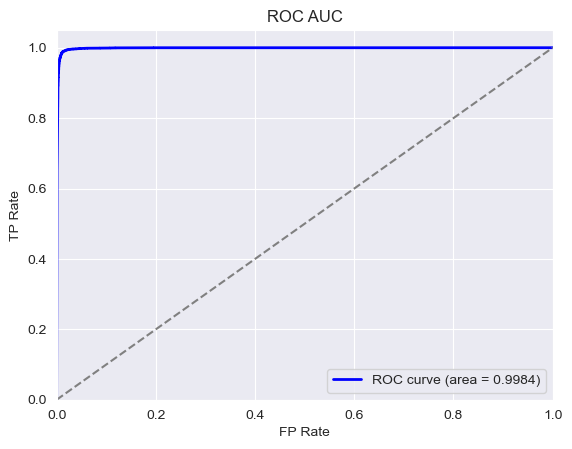

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Перевод модели в режим оценки
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Перемещение тестовых данных на GPU
X_test_tensor = X_test_tensor.to(device)
y_test = y_test.to(device)

# Отключение вычисления градиентов
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze(1)
    predictions = torch.sigmoid(outputs)
    predictions_cpu = predictions.cpu().numpy()
    y_test_cpu = y_test.cpu().numpy()
    
    roc_auc = roc_auc_score(y_test_cpu, predictions_cpu)
    print(f"ROC AUC: {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test_cpu, predictions_cpu)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.title('ROC AUC')
    plt.legend(loc="lower right")
    plt.show()


In [39]:
torch.save(model, "../models/model.pth")